# Zipline algorithm analysis example in pyfolio

Here's an example where we run an algorithm with zipline, then produce tear sheets for that algorithm.

## Imports
Import pyfolio and zipline, and ingest the pricing data for backtesting.

In [1]:
import sys
sys.path.append('/Users/george/Desktop/pyfolio/')

In [2]:
import pyfolio as pf
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')

import zipline
%load_ext zipline
# !zipline ingest

/Users/wellytambunan/opt/anaconda3/envs/zipline36/lib/python3.6/site-packages/empyrical/utils.py:32: UserWarning: Unable to import pandas_datareader. Suppressing import error and continuing. All data reading functionality will raise errors; but has been deprecated and will be removed in a later version.
  warnings.warn(msg)
/Users/wellytambunan/opt/anaconda3/envs/zipline36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Run our zipline algorithm
This algorithm can also be adjusted to execute a modified, or completely different, trading strategy.

In [3]:
%%zipline --bundle quantopian-quandl --start 2004-1-1 --end 2010-1-1 -o results.pickle

# Zipline trading algorithm
# Taken from zipline.examples.olmar

import numpy as np

from zipline.finance import commission, slippage

STOCKS = ['AMD', 'CERN', 'COST', 'DELL', 'GPS', 'INTC', 'MMM']


# On-Line Portfolio Moving Average Reversion

# More info can be found in the corresponding paper:
# http://icml.cc/2012/papers/168.pdf
def initialize(algo, eps=1, window_length=5):
    algo.stocks = STOCKS
    algo.sids = [algo.symbol(symbol) for symbol in algo.stocks]
    algo.m = len(algo.stocks)
    algo.price = {}
    algo.b_t = np.ones(algo.m) / algo.m
    algo.eps = eps
    algo.window_length = window_length

    algo.set_commission(commission.PerShare(cost=0))
    algo.set_slippage(slippage.FixedSlippage(spread=0))


def handle_data(algo, data):
    m = algo.m

    x_tilde = np.zeros(m)
    b = np.zeros(m)

    # find relative moving average price for each asset
    mavgs = data.history(algo.sids, 'price', algo.window_length, '1d').mean()
    for i, sid in enumerate(algo.sids):
        price = data.current(sid, "price")
        # Relative mean deviation
        x_tilde[i] = mavgs[sid] / price

    ###########################
    # Inside of OLMAR (algo 2)
    x_bar = x_tilde.mean()

    # market relative deviation
    mark_rel_dev = x_tilde - x_bar

    # Expected return with current portfolio
    exp_return = np.dot(algo.b_t, x_tilde)
    weight = algo.eps - exp_return
    variability = (np.linalg.norm(mark_rel_dev)) ** 2

    # test for divide-by-zero case
    if variability == 0.0:
        step_size = 0
    else:
        step_size = max(0, weight / variability)

    b = algo.b_t + step_size * mark_rel_dev
    b_norm = simplex_projection(b)
    np.testing.assert_almost_equal(b_norm.sum(), 1)

    rebalance_portfolio(algo, data, b_norm)

    # update portfolio
    algo.b_t = b_norm


def rebalance_portfolio(algo, data, desired_port):
    # rebalance portfolio
    for i, sid in enumerate(algo.sids):
        algo.order_target_percent(sid, desired_port[i])


def simplex_projection(v, b=1):
    """Projection vectors to the simplex domain
    Implemented according to the paper: Efficient projections onto the
    l1-ball for learning in high dimensions, John Duchi, et al. ICML 2008.
    Implementation Time: 2011 June 17 by Bin@libin AT pmail.ntu.edu.sg
    Optimization Problem: min_{w}\| w - v \|_{2}^{2}
    s.t. sum_{i=1}^{m}=z, w_{i}\geq 0
    Input: A vector v \in R^{m}, and a scalar z > 0 (default=1)
    Output: Projection vector w
    :Example:
    >>> proj = simplex_projection([.4 ,.3, -.4, .5])
    >>> print(proj)
    array([ 0.33333333, 0.23333333, 0. , 0.43333333])
    >>> print(proj.sum())
    1.0
    Original matlab implementation: John Duchi (jduchi@cs.berkeley.edu)
    Python-port: Copyright 2013 by Thomas Wiecki (thomas.wiecki@gmail.com).
    """

    v = np.asarray(v)
    p = len(v)

    # Sort v into u in descending order
    v = (v > 0) * v
    u = np.sort(v)[::-1]
    sv = np.cumsum(u)

    rho = np.where(u > (sv - b) / np.arange(1, p + 1))[0][-1]
    theta = np.max([0, (sv[rho] - b) / (rho + 1)])
    w = (v - theta)
    w[w < 0] = 0
    return w

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2004-01-02 21:00:00+00:00,NaN,0.000000,NaN,-0.000498,NaN,NaN,0.00,1.000000e+07,0.000000e+00,0.000000e+00,...,0.0,0.0,0,NaN,1.000000e+07,0.000000e+00,0.000000e+00,1,[],0.0
2004-01-05 21:00:00+00:00,0.000000,0.000000,0.000000,0.010329,0.127173,0.000000,-10126174.69,-1.261747e+05,1.012617e+07,1.012617e+07,...,0.0,0.0,0,NaN,1.000000e+07,0.000000e+00,0.000000e+00,2,"[{'amount': 96135, 'dt': 2004-01-05 21:00:00+0...",0.0
2004-01-06 21:00:00+00:00,0.072181,0.007876,0.936816,0.011324,0.097751,-0.289509,109778.05,-1.639664e+04,1.009515e+07,1.009515e+07,...,0.0,0.0,0,NaN,-1.261747e+05,1.012617e+07,1.012617e+07,3,"[{'amount': -10573, 'dt': 2004-01-06 21:00:00+...",0.0
2004-01-07 21:00:00+00:00,0.064700,0.013911,1.152581,0.014808,0.079856,-0.300093,38085.58,2.168894e+04,1.011742e+07,1.011742e+07,...,0.0,0.0,0,NaN,-1.639664e+04,1.009515e+07,1.009515e+07,4,"[{'amount': -85562, 'dt': 2004-01-07 21:00:00+...",0.0
2004-01-08 21:00:00+00:00,0.202012,-0.010293,-0.158788,0.018790,0.069177,-0.366962,16041.11,3.773005e+04,9.859335e+06,9.859335e+06,...,0.0,0.0,0,-2.976346,2.168894e+04,1.011742e+07,1.011742e+07,5,"[{'amount': -5801, 'dt': 2004-01-08 21:00:00+0...",0.0
2004-01-09 21:00:00+00:00,0.181373,-0.009865,-0.292936,0.009955,0.101473,-0.259677,-35531.75,2.198300e+03,9.899151e+06,9.899151e+06,...,0.0,0.0,0,-2.599506,3.773005e+04,9.859335e+06,9.859335e+06,6,"[{'amount': -1488, 'dt': 2004-01-09 21:00:00+0...",0.0
2004-01-12 21:00:00+00:00,0.169326,-0.005593,-0.124511,0.017422,0.098792,-0.103514,-3421.09,-1.222790e+03,9.945296e+06,9.945296e+06,...,0.0,0.0,0,-1.322191,2.198300e+03,9.899151e+06,9.899151e+06,7,"[{'amount': 832, 'dt': 2004-01-12 21:00:00+00:...",0.0
2004-01-13 21:00:00+00:00,0.162112,-0.013656,-0.457976,0.011448,0.102791,0.101361,-584.85,-1.807640e+03,9.865248e+06,9.865248e+06,...,0.0,0.0,0,-2.976155,-1.222790e+03,9.945296e+06,9.945296e+06,8,"[{'amount': -803, 'dt': 2004-01-13 21:00:00+00...",0.0
2004-01-14 21:00:00+00:00,0.156519,-0.008078,-0.340093,0.019910,0.102896,0.222663,231.70,-1.575940e+03,9.920795e+06,9.920795e+06,...,0.0,0.0,0,-1.619050,-1.807640e+03,9.865248e+06,9.865248e+06,9,"[{'amount': 1865, 'dt': 2004-01-14 21:00:00+00...",0.0
2004-01-15 21:00:00+00:00,0.147708,-0.010202,-0.373287,0.022399,0.097018,0.221846,-3049.47,-4.625410e+03,9.902601e+06,9.902601e+06,...,0.0,0.0,0,-1.955354,-1.575940e+03,9.920795e+06,9.920795e+06,10,"[{'amount': 8290, 'dt': 2004-01-15 21:00:00+00...",0.0


## Extract metrics
Get the returns, positions, and transactions from the zipline backtest object.

In [4]:
import pandas as pd

results = pd.read_pickle('results.pickle')
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

## Single plot example
Make one plot of the top 5 drawdown periods.

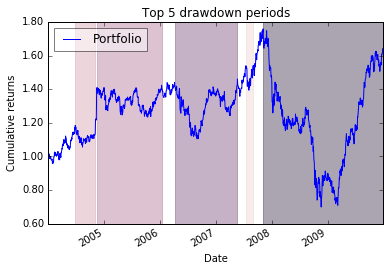

In [5]:
pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')

## Full tear sheet example
Create a full tear sheet for our algorithm. As an example, set the live start date to something arbitrary.

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,60.30,2007-11-06,2008-11-20,NaT,NaN
1,23.25,2006-04-06,2006-09-07,2007-05-22,294
2,12.51,2004-11-15,2005-10-12,2006-01-11,303
3,10.90,2004-06-25,2004-08-12,2004-11-04,95
4,9.47,2007-07-16,2007-08-06,2007-09-04,37


Stress Events,mean,min,max
Lehman,-0.28%,-7.42%,4.40%
Aug07,0.35%,-2.96%,3.03%
Mar08,-0.43%,-3.10%,3.34%
Sept08,-0.68%,-7.42%,3.99%
2009Q1,-0.35%,-4.98%,3.36%
2009Q2,0.71%,-3.78%,6.17%
Low Volatility Bull Market,0.01%,-6.11%,6.45%
GFC Crash,-0.08%,-7.58%,9.71%
Recovery,0.32%,-3.78%,6.17%


Top 10 long positions of all time,max
sid,
COST,100.75%
MMM,92.36%
CERN,84.47%
DELL,72.76%
AMD,71.05%
INTC,69.19%
GPS,62.11%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
COST,100.75%
MMM,92.36%
CERN,84.47%
DELL,72.76%
AMD,71.05%
INTC,69.19%
GPS,62.11%


TypeError: slice indices must be integers or None or have an __index__ method

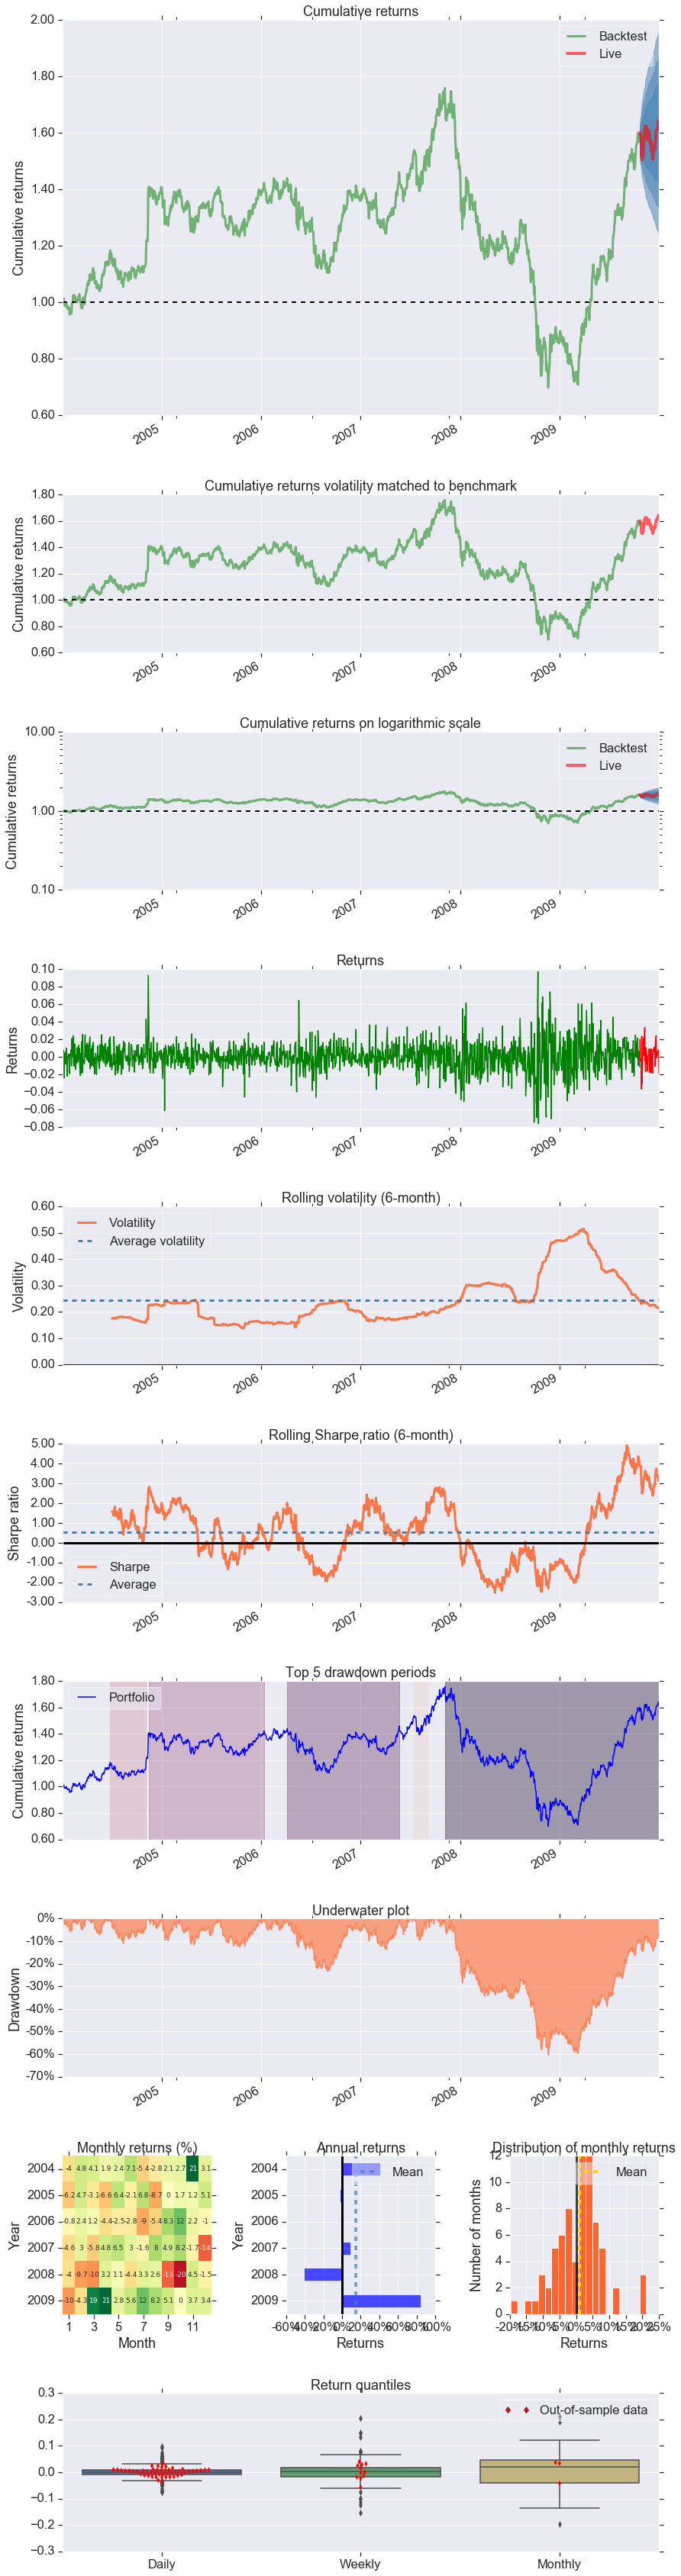

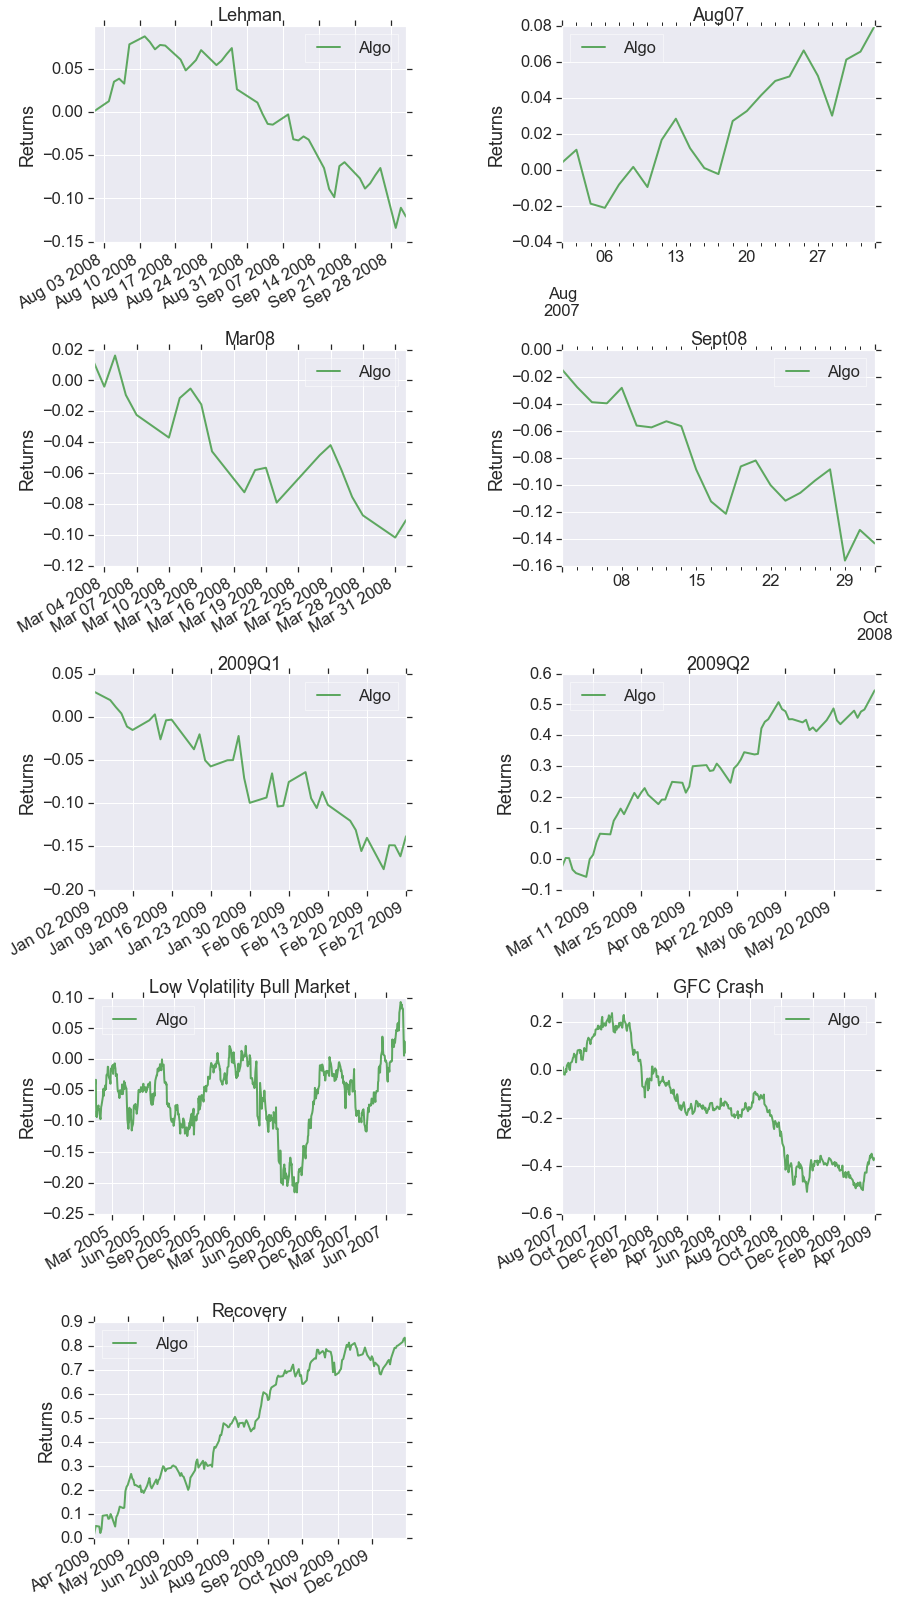

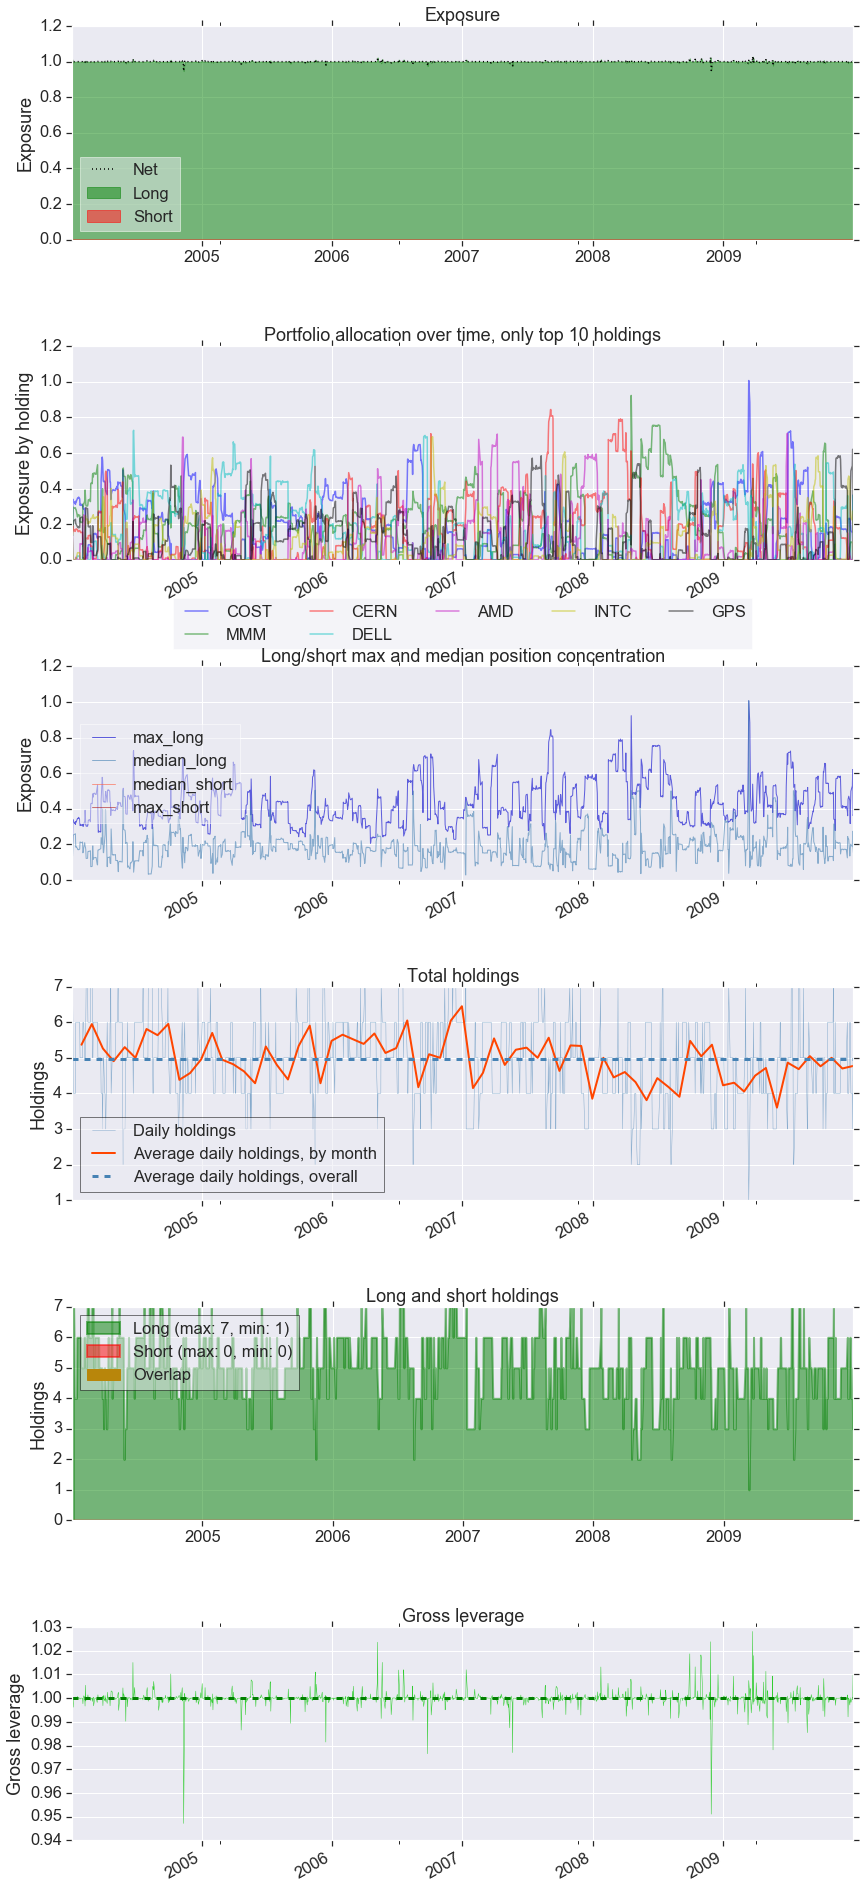

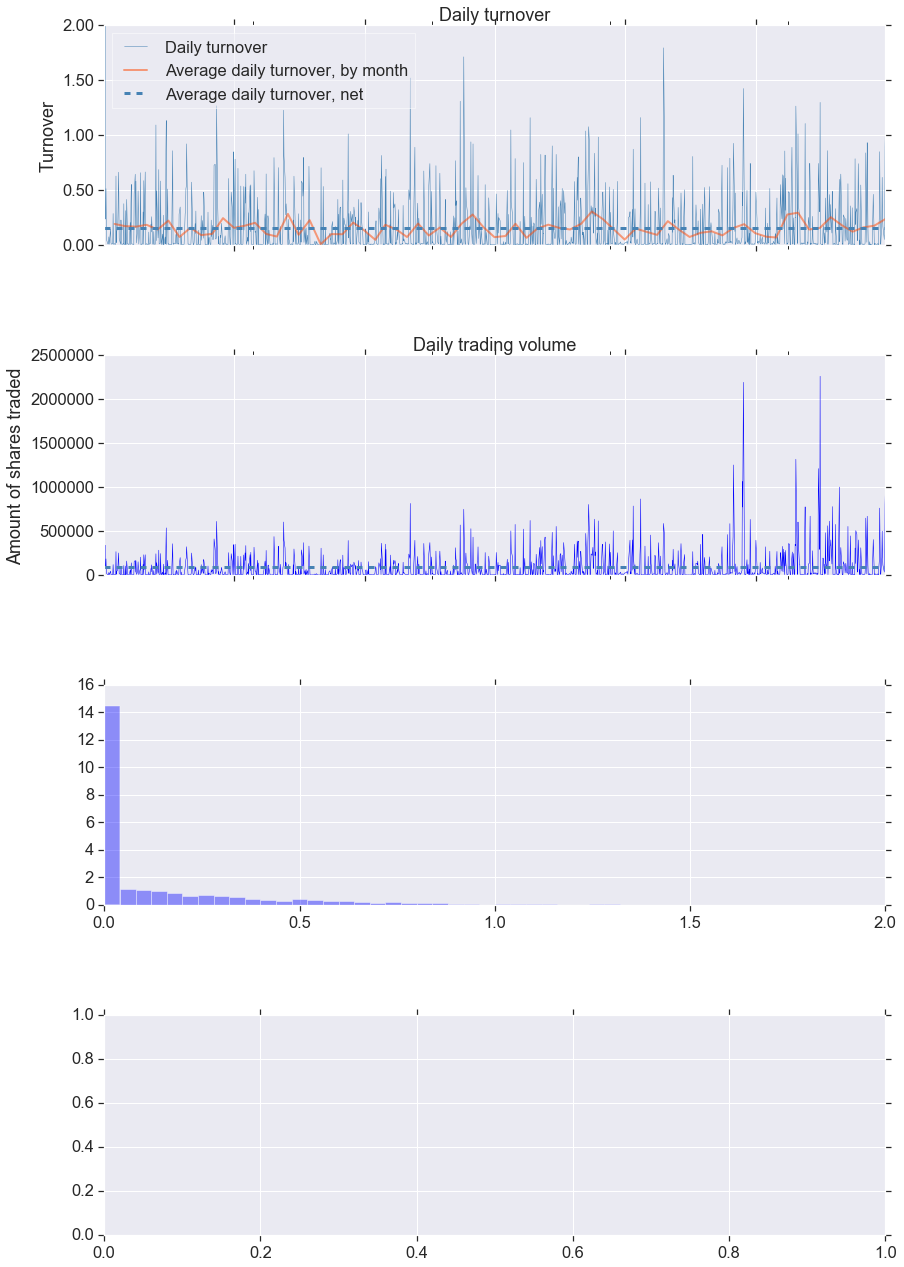

In [6]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          live_start_date='2009-10-22', round_trips=True)

## Suppressing symbol output

When sharing tear sheets it might be undesirable to display which symbols where used by a strategy. To suppress these in the tear sheet you can pass `hide_positions=True`.

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,60.30,2007-11-06,2008-11-20,NaT,NaN
1,23.25,2006-04-06,2006-09-07,2007-05-22,294
2,12.51,2004-11-15,2005-10-12,2006-01-11,303
3,10.90,2004-06-25,2004-08-12,2004-11-04,95
4,9.47,2007-07-16,2007-08-06,2007-09-04,37


Stress Events,mean,min,max
Lehman,-0.28%,-7.42%,4.40%
Aug07,0.35%,-2.96%,3.03%
Mar08,-0.43%,-3.10%,3.34%
Sept08,-0.68%,-7.42%,3.99%
2009Q1,-0.35%,-4.98%,3.36%
2009Q2,0.71%,-3.78%,6.17%
Low Volatility Bull Market,0.01%,-6.11%,6.45%
GFC Crash,-0.08%,-7.58%,9.71%
Recovery,0.32%,-3.78%,6.17%


TypeError: slice indices must be integers or None or have an __index__ method

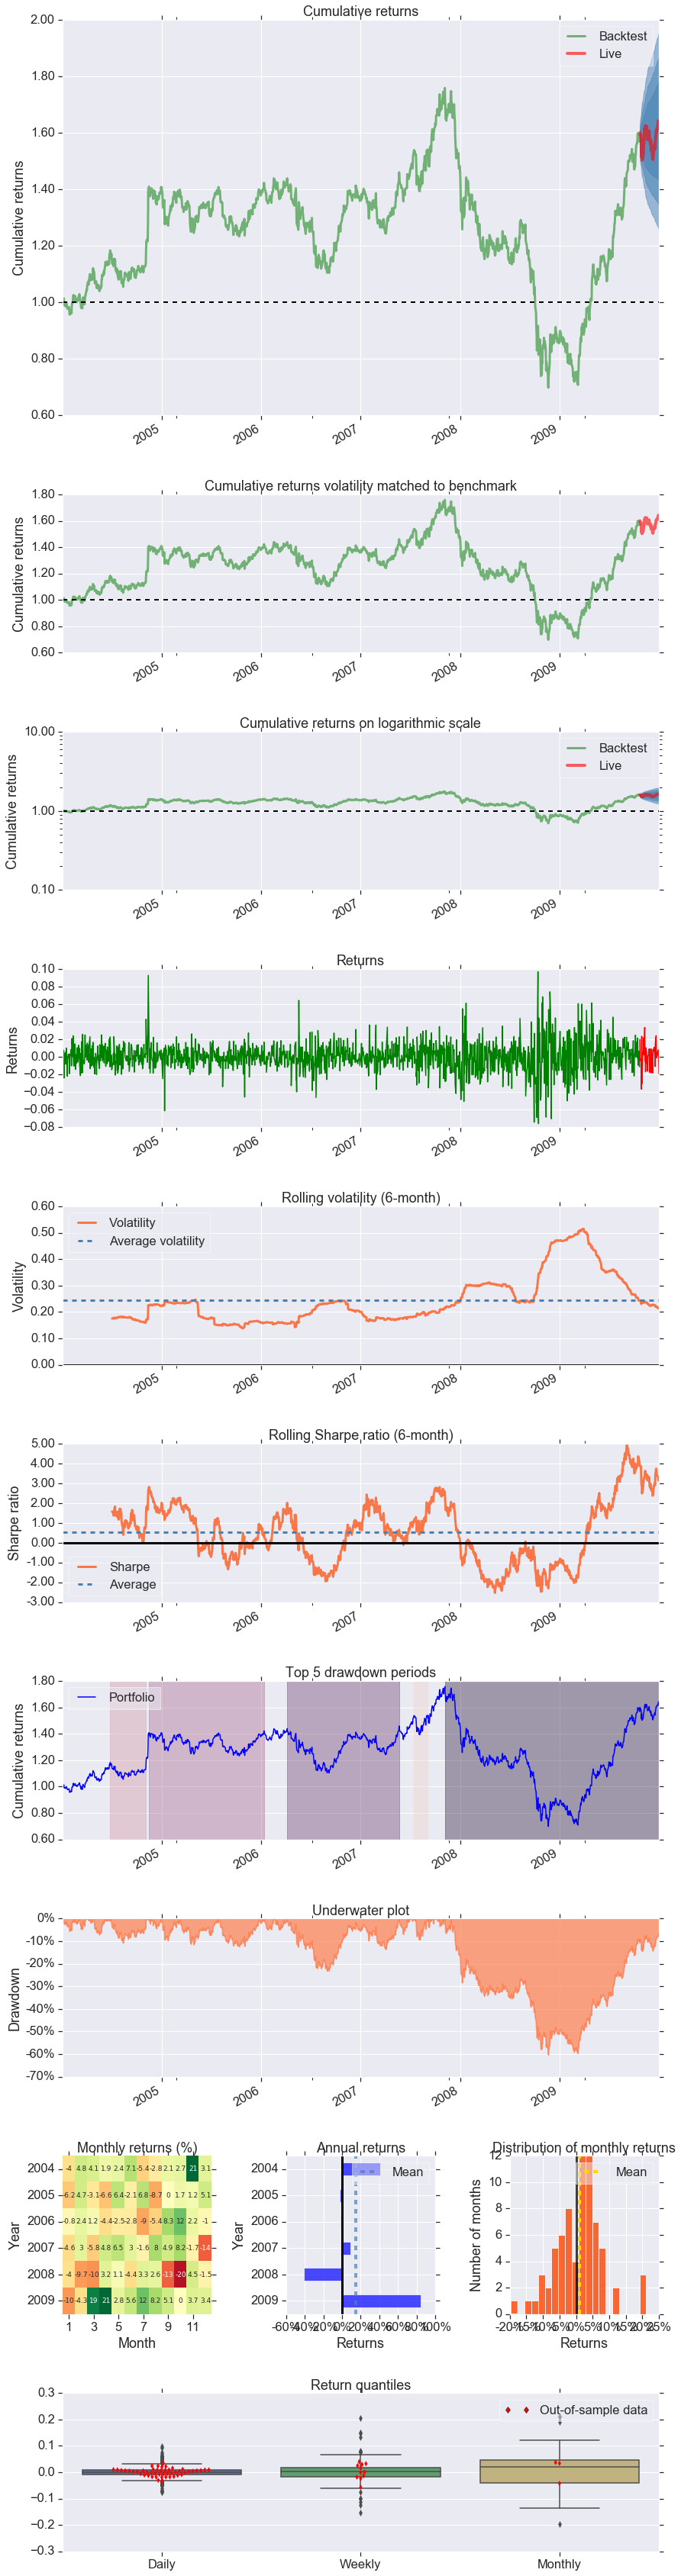

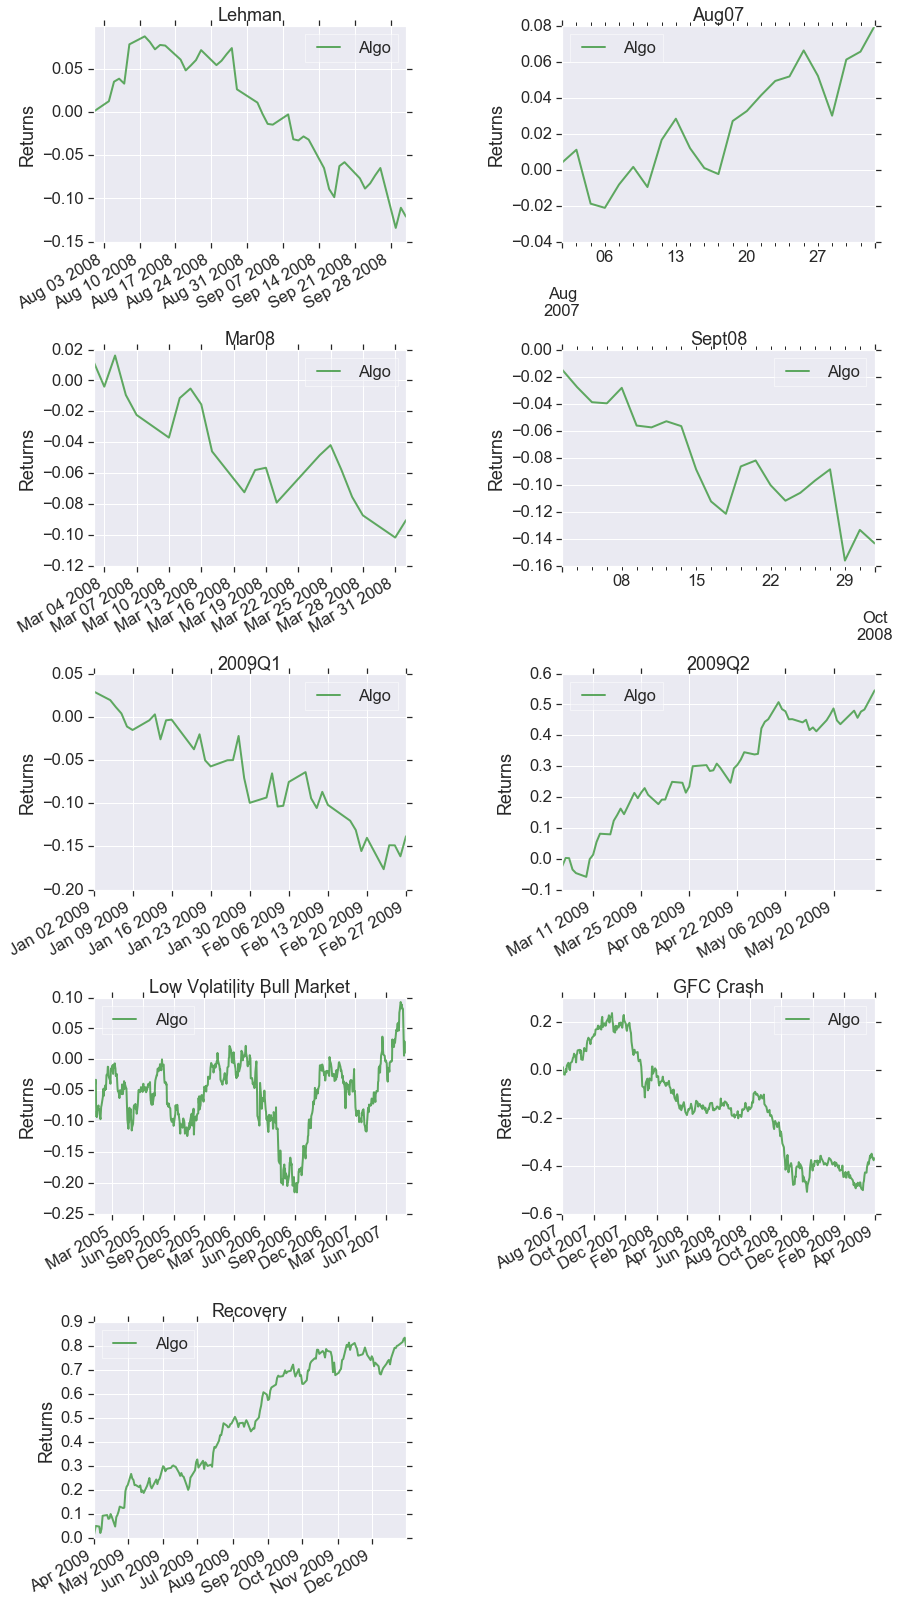

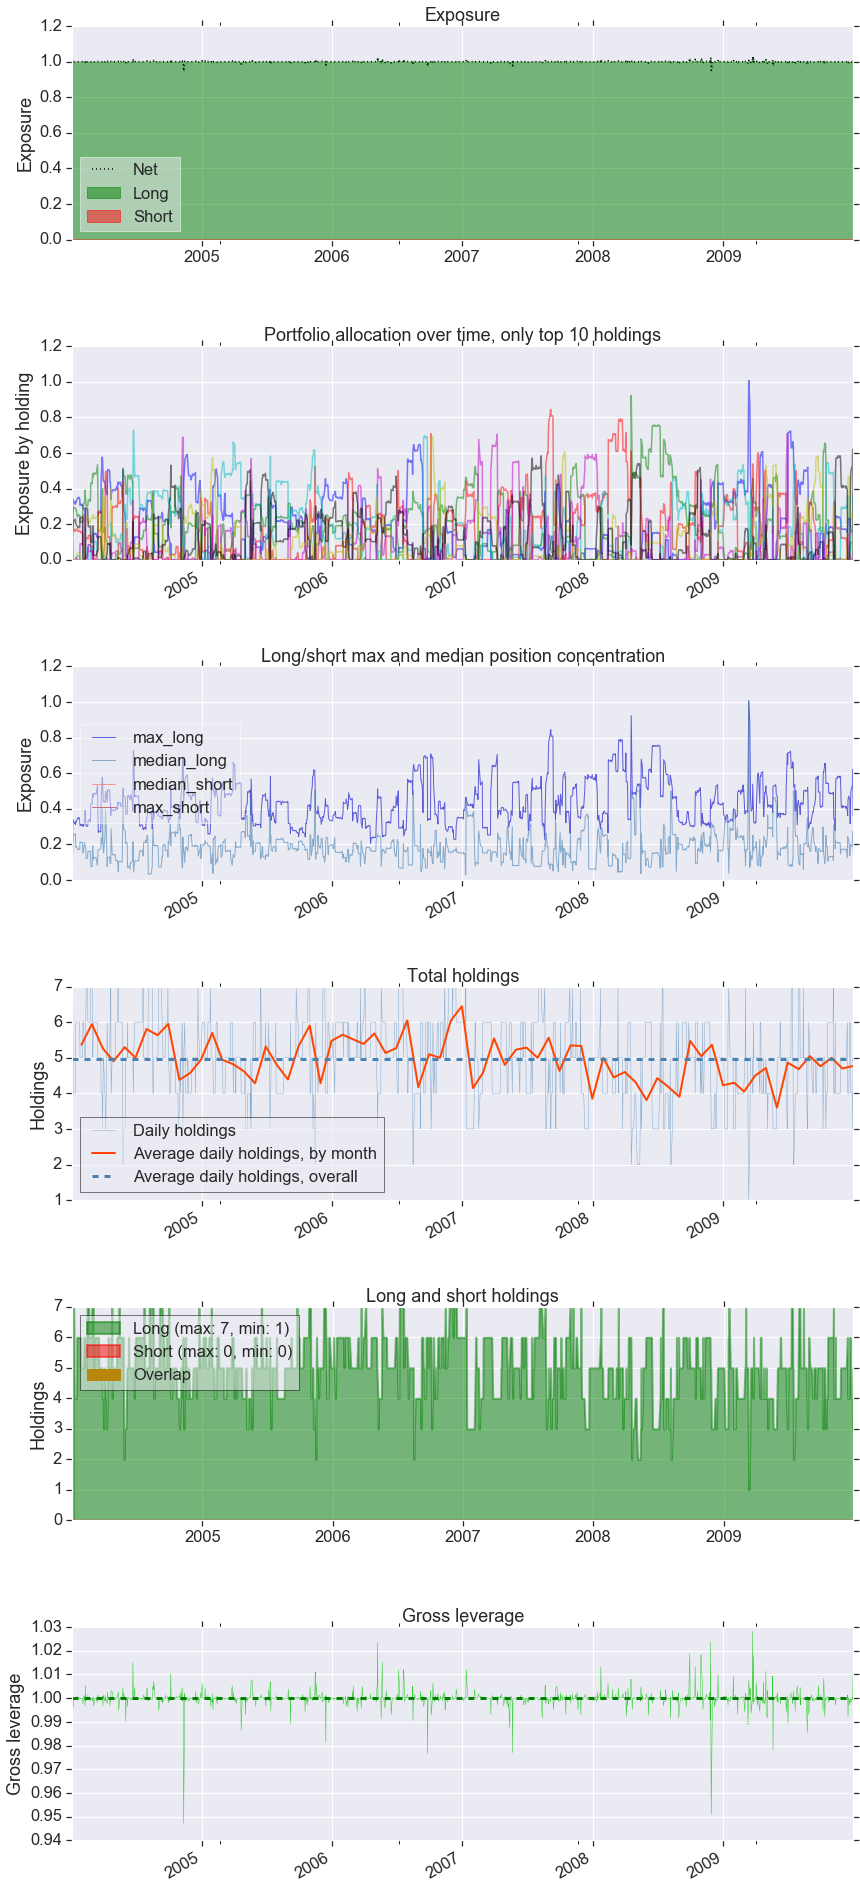

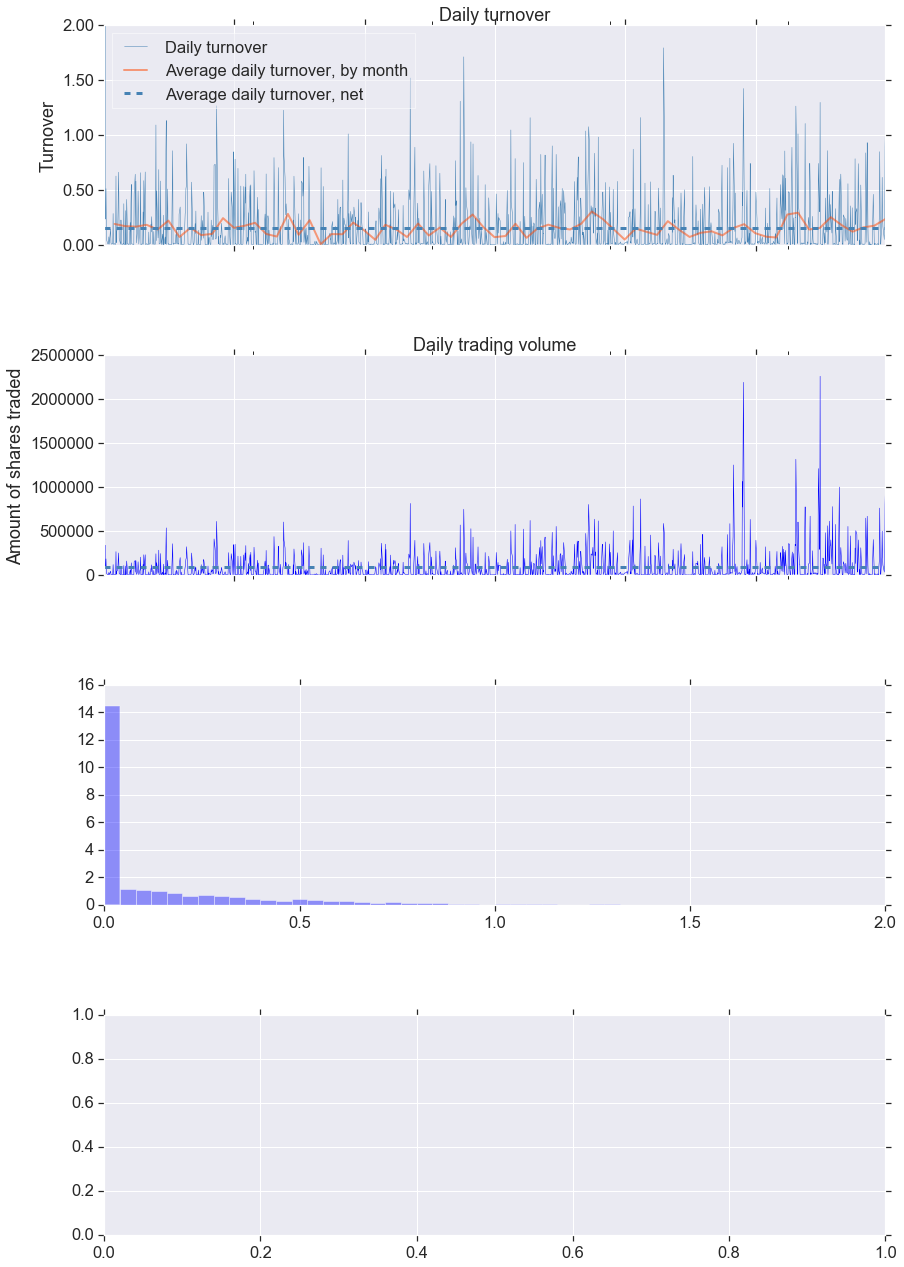

In [7]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          live_start_date='2009-10-22', hide_positions=True)